In [ ]:
!pip install tensorflow-addons
import tensorflow as tf
from tensorflow.keras import layers

@tf.keras.utils.register_keras_serializable()
class InstanceNormalization(tf.keras.layers.Layer):
    """Instance Normalization Layer (Keras-compatible)"""

    def _init_(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self)._init_(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

    def get_config(self):
        config = super().get_config()
        config.update({"epsilon": self.epsilon})
        return config

generator = tf.keras.models.load_model(
    "/van_gogh_generator_200.keras",
    custom_objects={"InstanceNormalization": InstanceNormalization},
    safe_mode=False
)
print("✅ Model loaded successfully!")

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
import tensorflow_datasets as tfds

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
dataset, metadata = tfds.load('cycle_gan/vangogh2photo',
                              with_info=True, as_supervised=True)

train_normal, train_van = dataset['trainB'], dataset['trainA']
test_normal, test_van = dataset['testB'], dataset['testA']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/vangogh2photo/incomplete.HNVCEL_3.0.0/cycle_gan-trainA.tfrecord*…

Generating trainB examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/vangogh2photo/incomplete.HNVCEL_3.0.0/cycle_gan-trainB.tfrecord*…

Generating testA examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/vangogh2photo/incomplete.HNVCEL_3.0.0/cycle_gan-testA.tfrecord*.…

Generating testB examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/vangogh2photo/incomplete.HNVCEL_3.0.0/cycle_gan-testB.tfrecord*.…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/vangogh2photo/3.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

### Preprocessing the Images.

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
train_normal = train_normal.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_van = train_van.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_normal = test_normal.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_van = test_van.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

* Adding jitter to image data.

In [ ]:
sample_normal = next(iter(train_normal))
sample_van = next(iter(train_van))

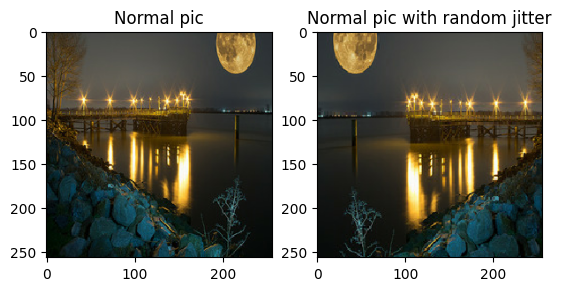

In [ ]:
plt.subplot(121)
plt.title('Normal pic')
plt.imshow(sample_normal[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Normal pic with random jitter')
plt.imshow(random_jitter(sample_normal[0]) * 0.5 + 0.5)

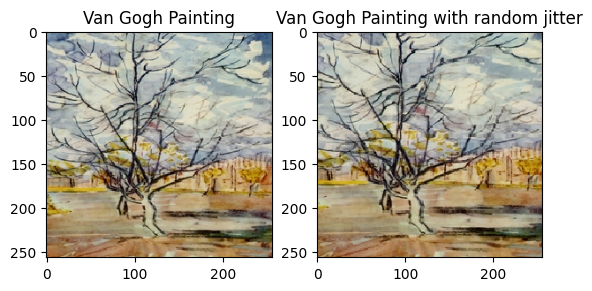

In [ ]:
plt.subplot(121)
plt.title('Van Gogh Painting')
plt.imshow(sample_van[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Van Gogh Painting with random jitter')
plt.imshow(random_jitter(sample_van[0]) * 0.5 + 0.5)

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, norm_type='instancenorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(sample_van[0], 0))
print (down_result.shape)

(1, 128, 128, 3)


In [ ]:
def upsample(filters, size, norm_type='instancenorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [ ]:
def unet_generator(output_channels, norm_type='instancenorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

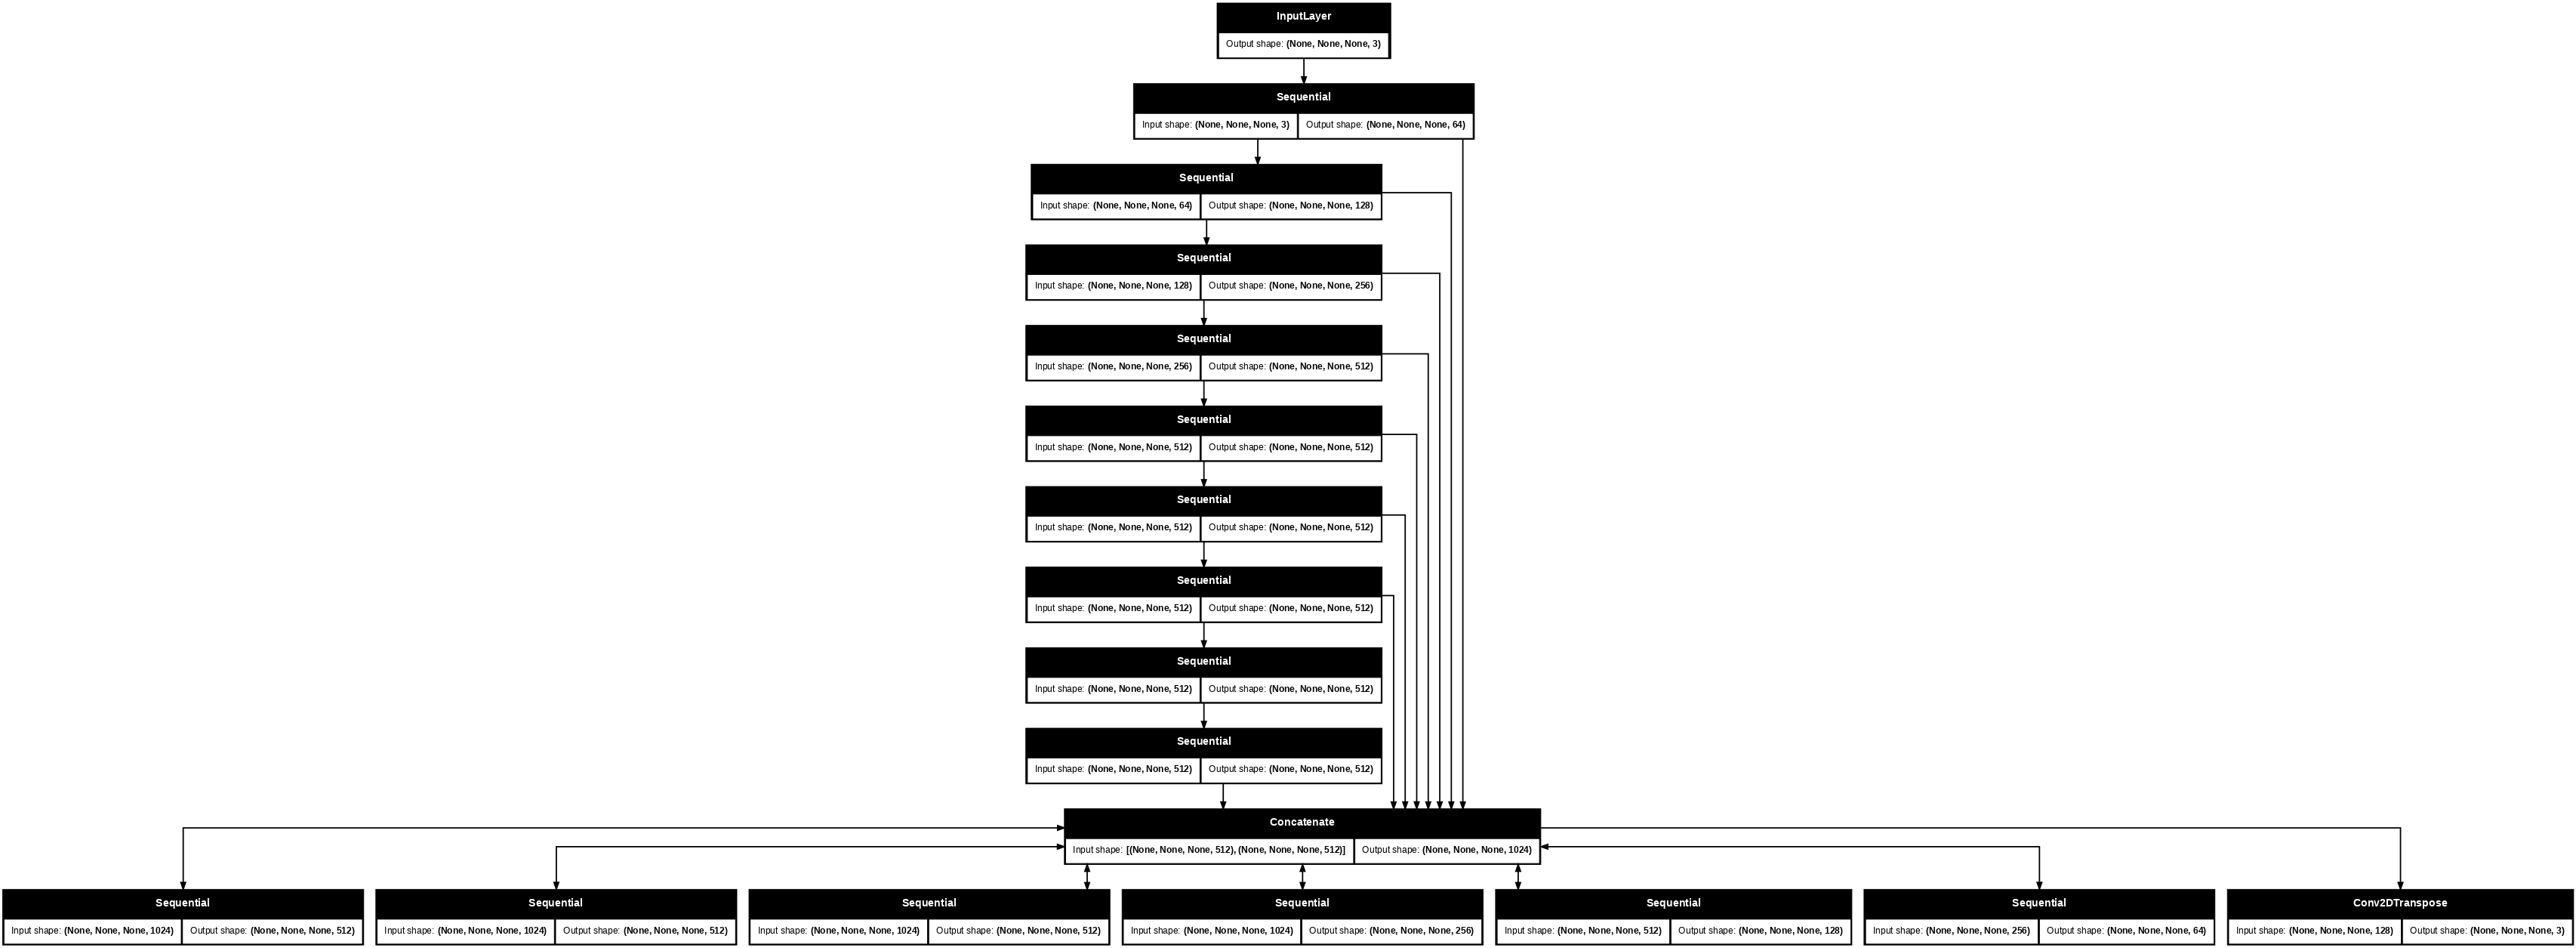

In [ ]:
generator = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

* The generator Architecture.

In [ ]:
def discriminator(norm_type='instancenorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)


In [ ]:
generator_a = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_b = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

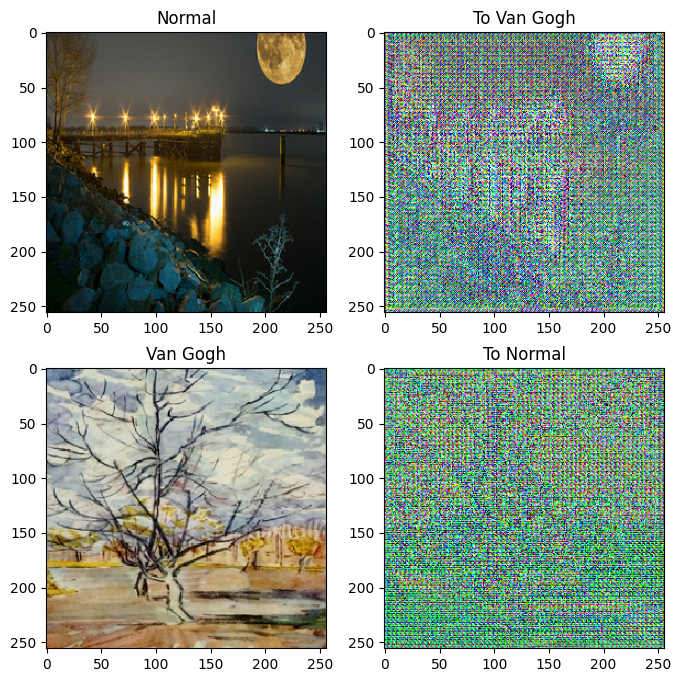

In [ ]:
to_van = generator_a(sample_normal)
to_normal = generator_b(sample_van)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_normal, to_van, sample_van, to_normal]
title = ['Normal', 'To Van Gogh', 'Van Gogh', 'To Normal']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

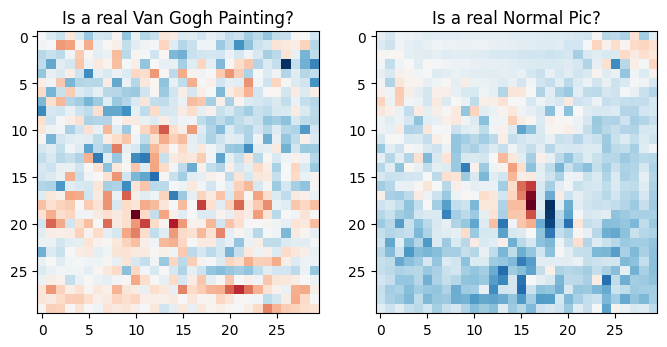

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real Van Gogh Painting?')
plt.imshow(discriminator_y(sample_van)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real Normal Pic?')
plt.imshow(discriminator_x(sample_normal)[0, ..., -1], cmap='RdBu_r')

plt.show()

### Calculating the loss.

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input x and the target y pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_a_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_b_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
!pip install open_clip_torch ftfy regex tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [ ]:
import open_clip
import torch
from PIL import Image
import torchvision.transforms as transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess_clip = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [ ]:
def compute_clip_loss_tf(image_tensor):
    def _clip_loss(image_np):
        from PIL import Image
        import numpy as np
        import torch.nn.functional as F

        # Convert image from [-1, 1] → [0, 255] and to PIL
        img = ((image_np + 1.0) * 127.5).astype(np.uint8)
        img = Image.fromarray(img[0])  # remove batch dimension

        # Preprocess for CLIP
        img_clip = preprocess_clip(img).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = model.encode_image(img_clip)
            text_tokens = tokenizer(["a painting in the style of Van Gogh"]).to(device)
            text_features = model.encode_text(text_tokens)

            # Normalize and calculate cosine similarity
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            similarity = F.cosine_similarity(image_features, text_features)
            loss = 1.0 - similarity.item()
            return np.array(loss, dtype=np.float32)

    return tf.numpy_function(_clip_loss, [image_tensor], tf.float32)


In [ ]:
import tensorflow as tf
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_a=generator_a,
                           generator_b=generator_b,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_a_optimizer=generator_a_optimizer,
                           generator_b_optimizer=generator_b_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 250

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Painting']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_a(real_x, training=True)
    cycled_x = generator_b(fake_y, training=True)

    fake_x = generator_b(real_y, training=True)
    cycled_y = generator_a(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_b(real_x, training=True)
    same_y = generator_a(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_a_loss = generator_loss(disc_fake_y)
    gen_b_loss = generator_loss(disc_fake_x)

    clip_loss = compute_clip_loss_tf(fake_y)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_a_loss = gen_a_loss + total_cycle_loss + identity_loss(real_y, same_y) + clip_loss * 5.0
    total_gen_b_loss = gen_b_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_a_gradients = tape.gradient(total_gen_a_loss,
                                        generator_a.trainable_variables)
  generator_b_gradients = tape.gradient(total_gen_b_loss,
                                        generator_b.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_a_optimizer.apply_gradients(zip(generator_a_gradients,
                                            generator_a.trainable_variables))

  generator_b_optimizer.apply_gradients(zip(generator_b_gradients,
                                            generator_b.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

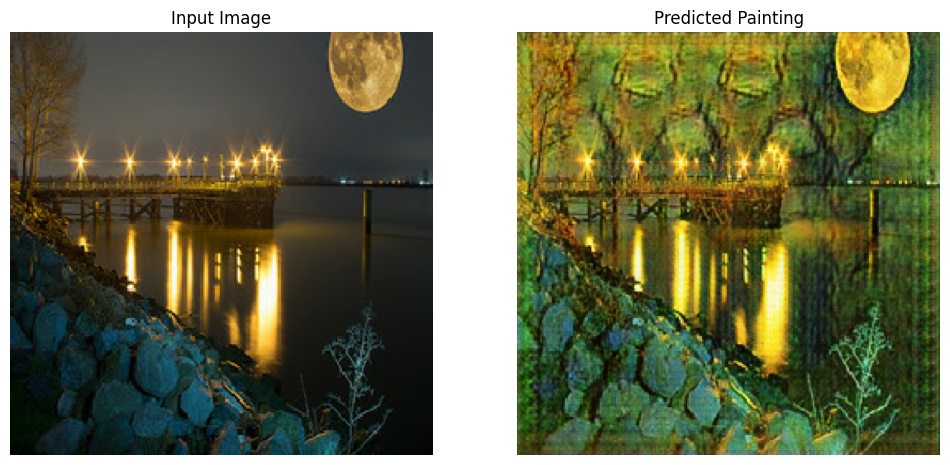

Time taken for epoch 28 is 33.168245792388916 sec

.....................................

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_normal, train_van)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_a, sample_normal)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

for inp in test_normal.take(10):
  generate_images(generator_a, inp)

for inp in test_normal.take(10):
  generate_images(generator_a, inp)

generator_a.save('/content/van_gogh_generator_250.keras')
import os
print(os.path.exists('/content/van_gogh_generator_250.keras'))

from google.colab import files

# Trigger the download
files.download('van_gogh_generator_250.keras')

In [ ]:
from google.colab import files

# Trigger the download
files.download('van_gogh_generator_250.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf


# Register custom objects
#custom_objects = {"InstanceNormalization": tfa.layers.InstanceNormalization}

# Load model with custom layers
#model = tf.keras.models.load_model("van_gogh_generator.keras", custom_objects=custom_objects)

#print("Model loaded successfully!")


In [ ]:
from google.colab import files
from PIL import Image
import tensorflow as tf
import numpy as np

uploaded = files.upload()

for filename in uploaded.keys():
    image_path = filename  # Get the uploaded file name
    print("Uploaded:", image_path)


Saving WhatsApp Image 2025-04-16 at 18.59.02.jpeg to WhatsApp Image 2025-04-16 at 18.59.02.jpeg
Uploaded: WhatsApp Image 2025-04-16 at 18.59.02.jpeg


In [ ]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((256, 256))  # Resize to match the model input size
    image = np.array(image) / 127.5 - 1  # Normalize to [-1, 1]
    return tf.expand_dims(image, axis=0)  # Add batch dimension

input_image = preprocess_image(image_path)


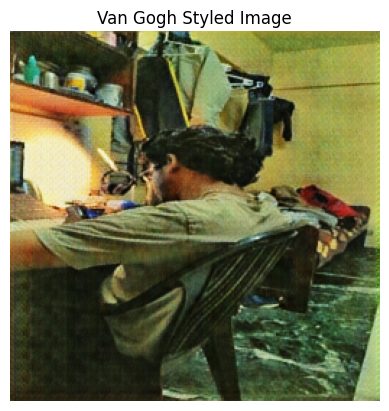

In [ ]:
van_gogh_styled = generator_a(input_image, training=False)

styled_image = (van_gogh_styled[0].numpy() * 0.5 + 0.5) * 255
styled_image = np.clip(styled_image, 0, 255).astype(np.uint8)

import matplotlib.pyplot as plt

plt.imshow(styled_image)
plt.axis('off')
plt.title("Van Gogh Styled Image")
plt.show()


In [ ]:
!pip install open_clip_torch ftfy regex tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
import open_clip
import torch
from PIL import Image
import torchvision.transforms as transforms


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess_clip = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [ ]:
from PIL import Image
Image.fromarray(styled_image).save("styled_output.png")


In [ ]:
image_clip = preprocess_clip(Image.open("styled_output.png").convert("RGB")).unsqueeze(0).to(device)


In [ ]:
texts = [
    "a painting in the style of Van Gogh",
    "a realistic photograph",
    "a digital artwork",
    "a pencil sketch",
    "an abstract painting"
]

text_tokens = tokenizer(texts).to(device)


In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_clip)
    text_features = model.encode_text(text_tokens)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)


In [ ]:
print("CLIP Evaluation Results:\n")
for i, score in enumerate(similarity[0]):
    print(f"{texts[i]}: {score.item():.4f}")


CLIP Evaluation Results:

a painting in the style of Van Gogh: 0.0204
a realistic photograph: 0.8253
a digital artwork: 0.0515
a pencil sketch: 0.0253
an abstract painting: 0.0775


In [ ]:
import numpy as np
import tensorflow as tf
from scipy.linalg import sqrtm
#import tensorflow_addons as tfa
from tensorflow.image import ssim, psnr
import matplotlib.pyplot as plt

# Load InceptionV3 for FID
inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Preprocessing for InceptionV3
def preprocess_for_inception(images):
    images = tf.image.resize(images, (299, 299))  # Resize to 299x299
    images = (images + 1.0) * 127.5  # [-1, 1] → [0, 255]
    return tf.keras.applications.inception_v3.preprocess_input(images)

# Get activations for FID
def get_activations(images):
    images = preprocess_for_inception(images)
    return inception_model(images).numpy()

# FID calculation
def calculate_fid(act1, act2):
    if act1.shape[0] == 1:
        act1 = np.concatenate([act1, act1], axis=0)
        act2 = np.concatenate([act2, act2], axis=0)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Evaluate generator_a on test_normal
def evaluate_generator(generator, dataset, num_samples=10):
    real_batch = []
    gen_batch = []
    ssim_scores = []
    psnr_scores = []

    for inp in dataset.take(num_samples):
        generated = generator(inp, training=False)
        real_img = inp[0]
        gen_img = generated[0]

        real_batch.append(real_img)
        gen_batch.append(gen_img)

        ssim_val = ssim(real_img, gen_img, max_val=1.0)
        psnr_val = psnr(real_img, gen_img, max_val=1.0)

        ssim_scores.append(ssim_val.numpy())
        psnr_scores.append(psnr_val.numpy())

    real_batch = tf.stack(real_batch)
    gen_batch = tf.stack(gen_batch)

    real_acts = get_activations(real_batch)
    gen_acts = get_activations(gen_batch)

    fid_score = calculate_fid(real_acts, gen_acts)
    avg_ssim = np.mean(ssim_scores)
    avg_psnr = np.mean(psnr_scores)

    print("\n📈 Performance Metrics on Test Set:")
    print(f"🌈 FID  : {fid_score:.2f}")
    print(f"🧠 SSIM : {avg_ssim:.4f}")
    print(f"🔧 PSNR : {avg_psnr:.2f} dB")

# Run evaluation
evaluate_generator(generator_a, test_normal, num_samples=10)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

📈 Performance Metrics on Test Set:
🌈 FID  : 164.33
🧠 SSIM : 0.5052
🔧 PSNR : 13.76 dB


In [ ]:
from google.colab import files

uploaded = files.upload()  # Opens a dialog to select files
